# Interpolation Table Accuracy
This is a notebook for evaluating the accuracy of our Action/Energy/Angular momentum interpolators

This notebook is here for verification purposes and it is not recommended that you deal with this unless you are really interested in the details

For the adiabatic matching, we require the initial phase space distribution function as a function of the actions, but is usually only known as a function of energy $f(E)$. Therefore we sample combinations E,J(E,L),L and use interpolators to parameterize f(J,L). 
Further we need to evaluate J(E,L) many times in the truncated profile. To speed up this process we also set up an interpolator for this. Here we check the accuracy of all these interpolation steps (reaching $10^{-3}$ relative accuracy, which is good enough for our purposes).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.append("../..")
import adiabatic_tides as at

In [2]:
nfw = at.profiles.NFWProfile(conc=10., m200c=1e9)
def sample_particles(n=1e5, rmaxfac=1., seed=137):
    #nfw = at.profiles.NFWProfile(conc=10., m200c=1e9)
    pos, vel, mass = nfw.sample_particles(ntot=int(n), rmax=rmaxfac, seed=seed)
    r, E, L = nfw.posvel_to_rEL(pos, vel)
    Jr = nfw.radial_action((r,E,L))
    f = nfw.f_of_e(E)
    return r, E, L, Jr, f

# Check Interpolation of J (E, L)

Here we check how accurate the interpolated function J(E,L) is in comparison to the direct calculation of J.

This interpolator is needed to speed up the actions calculation in the tidally truncated profile.

For this interpolator we use a (non-uniform) grid in E,L and interpolate with scipy.interpolate.RectBivariateSpline

For more details check the following functions:
* adiabatic_tides.profiles.RadialProfile._initialize_j_of_el
* adiabatic_tides.profiles.RadialProfile.j_of_el

/scratch/stuecker/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:372: RuntimeWarning: invalid value encountered in true_divide
  h0divh1 = h0 / h1
/scratch/stuecker/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:374: RuntimeWarning: invalid value encountered in true_divide
  y[slice1]*hsum*hsum/hprod +
<timed exec>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


CPU times: user 3.41 s, sys: 477 ms, total: 3.88 s
Wall time: 3.46 s


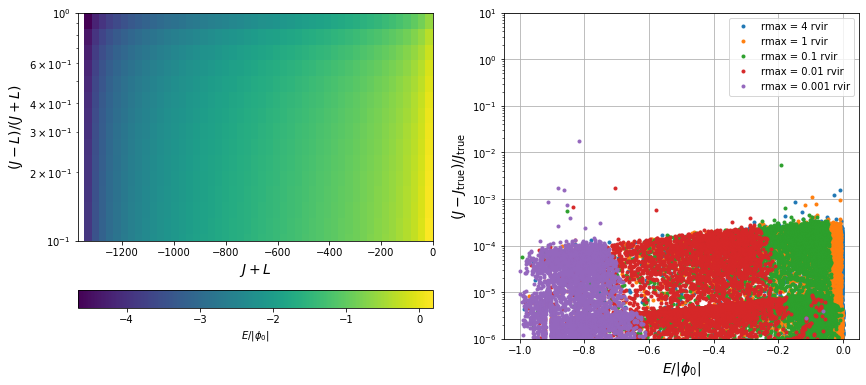

In [3]:
%%time
E = np.linspace(-1.,0.,50)*np.abs(nfw.phi0)
Em, Lfacm = np.meshgrid(E, np.logspace(-2.,0.,30))
lmin, lmax = nfw.lminmax_of_e(E)
Lm = lmin + Lfacm * (lmax-lmin)

fig, axs = plt.subplots(1,2, figsize=(14,6))
im = axs[0].pcolormesh(Em, Lfacm, np.log10(nfw.j_of_el(Em, Lm))) # , levels=np.linspace(-1.,0.,21)
cb = plt.colorbar(im, ax=axs[0], label=r"$E / |\phi_0|$", orientation="horizontal")

for rmaxfac in 4.,1.,0.1,1e-2,1e-3:
    r, E, L, Jr, f = sample_particles(n=1e4, rmaxfac=rmaxfac)
    
    #L / nfw.lrcirc_of_e(E)[0]
    axs[1].plot(E/ np.abs(nfw.phi0), np.abs(Jr-nfw.j_of_el(E,L))/ np.abs(Jr), 
                marker=".", linestyle="none", label=r"rmax = %.1g rvir" % rmaxfac) #, color=p[0].get_color()

axs[0].set_yscale("log")
axs[0].set_ylim(1e-1,1)
axs[1].set_yscale("log")
axs[1].set_ylim(1e-6,1e1)

axs[0].set_xlabel(r"$J + L$", fontsize=14)
axs[0].set_ylabel(r"$(J - L)/(J + L)$", fontsize=14)

axs[1].set_xlabel(r"$E / |\phi_0|$", fontsize=14)
axs[1].set_ylabel(r"$(J - J_{\rm{true}}) / J_{\rm{true}}$", fontsize=14)

axs[1].legend()
axs[1].grid("on")

# Check Interpolation of E0 (J, L)

Here we check how accurate the interpolated function E(J,L) is in comparison to direct samples of E,J(E,L),L

This interpolator is needed to find the initial energy level E0 of orbits with given actions in the initial NFW profile

This uses a mesh-free interpolator from samples E,J(E,L),L that are created on a grid in (E,L)

For more details check the following functions:
* adiabatic_tides.profiles.RadialProfile._initialize_e_of_jl
* adiabatic_tides.profiles.RadialProfile.e_of_jl

/scratch/stuecker/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:372: RuntimeWarning: invalid value encountered in true_divide
  h0divh1 = h0 / h1
/scratch/stuecker/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:374: RuntimeWarning: invalid value encountered in true_divide
  y[slice1]*hsum*hsum/hprod +


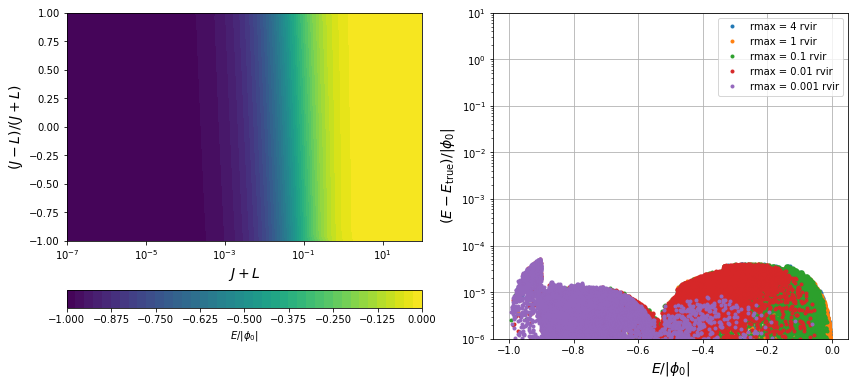

In [4]:
nfw = at.profiles.NFWProfile(conc=10., m200c=1e9)
JpL, JmL_over_JpL = np.meshgrid(np.logspace(-7, 2), np.linspace(-1,1))

JmL = JmL_over_JpL*JpL
Jm = 0.5*(JpL + JmL)
Lm = 0.5*(JpL - JmL)

fig, axs = plt.subplots(1,2, figsize=(14,6))
im = axs[0].contourf(JpL, JmL_over_JpL, nfw.e_of_jl(Jm, Lm)/np.abs(nfw.phi0), levels=np.linspace(-1.,0.,41))
cb = plt.colorbar(im, ax=axs[0], label=r"$E / |\phi_0|$", orientation="horizontal")

for rmaxfac in 4.,1.,0.1,1e-2,1e-3:
    pass
    r, E, L, Jr, f = sample_particles(n=1e4, rmaxfac=rmaxfac)
    
    axs[1].plot(E/ np.abs(nfw.phi0), np.abs(E-nfw.e_of_jl(Jr,L))/ np.abs(nfw.phi0), 
                marker=".", linestyle="none", label=r"rmax = %.1g rvir" % rmaxfac) #, color=p[0].get_color()

axs[1].set_yscale("log")
axs[1].set_ylim(1e-6,1e1)
axs[0].set_xscale("log")

axs[0].set_xlabel(r"$J + L$", fontsize=14)
axs[0].set_ylabel(r"$(J - L)/(J + L)$", fontsize=14)

axs[1].set_xlabel(r"$E / |\phi_0|$", fontsize=14)
axs[1].set_ylabel(r"$(E - E_{\rm{true}}) / |\phi_0|$", fontsize=14)

axs[1].legend()
axs[1].grid("on")

# Check how well we can reconstruct the distribution function as a function of the actions f(J,L)

This interpolator combines the last step with additionally using the phase space distribution function $f_0(J,L) = f_0(E(J,L))$. (Getting this quantity right is actually important)

CPU times: user 1.13 s, sys: 885 µs, total: 1.13 s
Wall time: 1.13 s


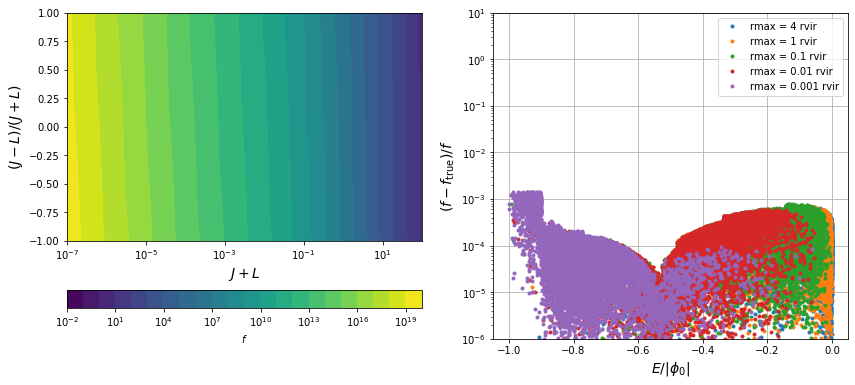

In [5]:
%%time
JpL, JmL_over_JpL = np.meshgrid(np.logspace(-7, 2), np.linspace(-1,1))

JmL = JmL_over_JpL*JpL
Jm = 0.5*(JpL + JmL)
Lm = 0.5*(JpL - JmL)

fig, axs = plt.subplots(1,2, figsize=(14,6))
from matplotlib.colors import LogNorm
im = axs[0].contourf(JpL, JmL_over_JpL, nfw.f_of_e(nfw.e_of_jl(Jm, Lm)), levels=np.logspace(-2.,20.,23), norm=LogNorm())
cb = plt.colorbar(im, ax=axs[0], label=r"$f$", orientation="horizontal")

for rmaxfac in 4.,1.,0.1,1e-2,1e-3:
    pass
    r, E, L, Jr, f = sample_particles(n=1e4, rmaxfac=rmaxfac)

    axs[1].plot(E/ np.abs(nfw.phi0), np.abs(f-nfw.f_of_e(nfw.e_of_jl(Jr,L)))/ np.abs(f), marker=".", 
                linestyle="none", label=r"rmax = %.1g rvir" % rmaxfac) 


axs[1].set_yscale("log")
axs[1].set_ylim(1e-6,1e1)
axs[0].set_xscale("log")

axs[0].set_xlabel(r"$J + L$", fontsize=14)
axs[0].set_ylabel(r"$(J - L)/(J + L)$", fontsize=14)

axs[1].set_xlabel(r"$E / |\phi_0|$", fontsize=14)
axs[1].set_ylabel(r"$(f - f_{\rm{true}})/f$", fontsize=14)

axs[1].legend()
axs[1].grid("on")